# VAR modeling 
To assess the relationship between Wallstreetbest sentiment and stock's data, we will use VAR models. 

The VAR model is a statistical model for forecasting time series data. The difference between VAR and other time series models like ARIMA, ARMA or GARCH, is that VAR allows for multivariate analysis, and can also be used with exogenous variables(pretty much timeseries modeling for endogenous and common regression for exogenous).

In [65]:
library(tidyverse);
library(recipes);
library(caret);
library(xts);
library(MTS);
library(tseries);
library(forecast);
library(vars);
library(lmtest);

Before training our model we need to deal with Null values by inputing the three missing values. Since our data is sequential, and we already have few observations, I prefered not to discard the row contsining the null values.
When fitting a VAR model we usually don't need to scale our variables so we will keep them as they are.

Some of the variables are highly correlated, for example r and logr represent the same thing, so we will keep only r for the sake of interpretability, logr might come handy in the furure to fit a GARCH model.

,r,d_vol,sent_avg,eng_var
r,1.00000000,-0.150856421,-0.074694295,0.04417403
d_vol,-0.15085642,1.000000000,0.002971014,0.07772463
sent_avg,-0.07469430,0.002971014,1.000000000,-0.13288172
eng_var,0.04417403,0.077724634,-0.132881721,1.00000000


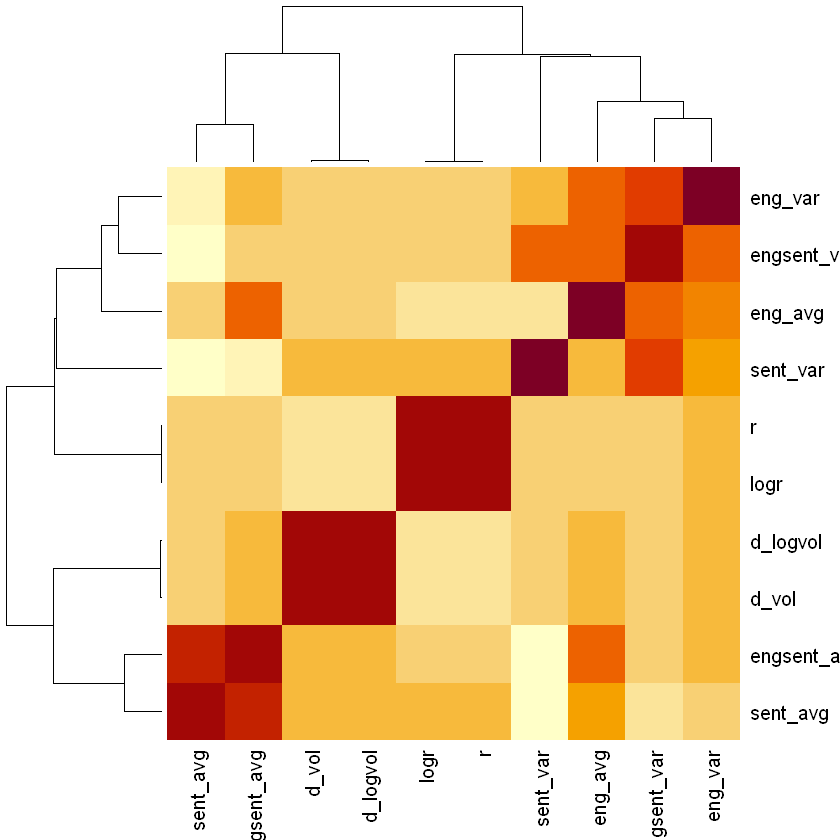

In [66]:
r50 <- read.csv(file = "../data/r50_2023.csv",
                header = TRUE,
                sep = ",",
                dec = ".")

# Center and scale
recipe <-
    recipe(~., data = r50) %>%
    step_impute_mean(all_numeric()) %>%
    step_select(-c(X, timestamp)) 

recipe <- prep(recipe, training = r50)

r50_clean <- bake(recipe, r50)

heatmap(cor(r50_clean))

r50_clean <- subset(r50_clean, select = -c(logr, d_logvol))
    
r50_clean <- r50_clean[c( "r", "d_vol", "sent_avg", "eng_var")] 

cor(r50_clean)



One of the key assumptions of VAR is the stationarity of the data, that is, that the time series have costant mean, costant variance and costant autocovariance. To make it simple, we don't want to have patterns or long term trends, but we want our time series to behave in a similar manner across different periods. 

We can assess stationarity by rejecting the null hypothesis of the Augmented Dickey-Fuller (ADF) test. In the table below we can see that all our feature are stationary, while sent_var might not be stationary. Due to the p-value we can assume that it should be stationary.

In [67]:
variables <- colnames(r50_clean)

adf_results <- data.frame(Variable = character(length(variables)), ADF_pValue = numeric(length(variables)))

# Perform the adf test to all variables
for (i in seq_along(variables)) {
    suppressWarnings(adf_result <- adf.test(r50_clean[[variables[i]]]))
    adf_results[i, "Variable"] <- variables[i]
    adf_results[i, "P_Value"] <- adf_result$p.value
}

# Print the variable names and p-values of adf test
head(adf_results[, c("Variable", "P_Value")],10)


,Variable,P_Value
,<chr>,<dbl>
1,r,0.01000000
2,d_vol,0.01000000
3,sent_avg,0.01437974
4,eng_var,0.01000000


Once we have checked that the time series respect the model assumptions we can prepare the dataset fot training and testing. We will have different datasets for VAR and VARX, this because VARX needs an additional dataset input for exogenolus variables, that will be treated like normal estimators, without taking into account their lag. In orderot explore the impact of sentiment we will analyse it both as endogenous and as exogenous variables.

In [68]:
# Train/Test split
idx <- round(nrow(r50_clean) * 0.9)

df_train <- head(r50_clean, idx) %>% na.omit()
df_test <- tail(r50_clean,
            nrow(r50_clean) - idx) %>%
            na.omit()

# Set r and d_vol as endogenous variables
endogenous <- c("r", "d_vol")

# Set sentiment variables as exogenous
exogenous <- c("sent_avg", "eng_var")

# VARX Exogenous
df_ex_train <- df_train[exogenous]
df_ex_test <- df_test[exogenous] 

# VARX Endogenous
df_end_train <- df_train[endogenous]
df_end_test <- df_test[endogenous]

Now that we have our training data, we can find the optimal number of lags to fit our model. VARoder and VARoderI both provide an insight on which is the bets lag, with the first one using statistical tests, the latter using impulse response functions. 

Both 

In [69]:
# Lag selection for VAR
VARorder(df_train, 10)
VARorderI(df_train, 10)

# Lag selection for VARX
VARselect(df_end_train, exogen = df_ex_train)

selected order: aic =  3 
selected order: bic =  0 
selected order: hq =  0 
Summary table:  
       p     AIC     BIC      HQ    M(p) p-value
 [1,]  0 -5.5905 -5.5905 -5.5905  0.0000  0.0000
 [2,]  1 -5.5598 -5.1648 -5.3996 24.5822  0.0775
 [3,]  2 -5.5958 -4.8057 -5.2754 29.4946  0.0208
 [4,]  3 -5.6056 -4.4204 -5.1249 25.9367  0.0549
 [5,]  4 -5.5442 -3.9639 -4.9033 18.9218  0.2727
 [6,]  5 -5.4545 -3.4792 -4.6535 15.8045  0.4667
 [7,]  6 -5.4155 -3.0452 -4.4543 18.7133  0.2838
 [8,]  7 -5.3954 -2.6300 -4.2739 19.0026  0.2685
 [9,]  8 -5.4187 -2.2583 -4.1370 20.7594  0.1879
[10,]  9 -5.3579 -1.8024 -3.9160 14.3161  0.5752
[11,] 10 -5.3942 -1.4436 -3.7921 18.9649  0.2705
selected order: aic =  3 
selected order: bic =  0 
selected order: hq =  0 
M statistic and its p-value 
      Mstat        pv
 [1,] 42.62 0.0003192
 [2,] 26.82 0.0435193
 [3,] 27.14 0.0400010
 [4,] 15.72 0.4724542
 [5,] 16.48 0.4196769
 [6,] 14.77 0.5413753
 [7,] 27.78 0.0335863
 [8,] 20.63 0.1930585
 [9,] 13.11 0.

,1,2,3,4,5,6,7,8,9,10
AIC(n),-1.130106e+01,-1.127729e+01,-1.122933e+01,-1.122768e+01,-1.126057e+01,-1.126118e+01,-1.127864e+01,-1.126263e+01,-1.126261e+01,-1.119967e+01
HQ(n),-1.119500e+01,-1.112880e+01,-1.103843e+01,-1.099435e+01,-1.098481e+01,-1.094301e+01,-1.091804e+01,-1.085960e+01,-1.081716e+01,-1.071179e+01
SC(n),-1.103893e+01,-1.091030e+01,-1.075749e+01,-1.065099e+01,-1.057902e+01,-1.047478e+01,-1.038739e+01,-1.026652e+01,-1.016165e+01,-9.993853e+00
FPE(n),1.236193e-05,1.266315e-05,1.329228e-05,1.332538e-05,1.290988e-05,1.292325e-05,1.272722e-05,1.296849e-05,1.301338e-05,1.391722e-05


Our first VAR model will have a ton of variables, because each of the lags of each feature will be a variable itself. So to reduce complexity we will just remove the variables whose coefficients have a p-value smaller than 0.05 and we will re-fit the model accordingly. Once we refined our model we can then check how returns are affected by sudden changes in sentiment.  


VAR Estimation Results:
Endogenous variables: r, d_vol, sent_avg, eng_var 
Deterministic variables: const 
Sample size: 106 
Log Likelihood: -261.89 
Roots of the characteristic polynomial:
0.7653 0.6667 0.6667 0.5798 0.5798 0.5585 0.5585 0.467 0.467 0.3186 0.3186 0.2302
Call:
VAR(y = df_train, p = 3)


Estimation results for equation r: 
r = r.l1 + r.l3 + eng_var.l3 + const 

             Estimate Std. Error t value Pr(>|t|)
r.l1       -1.481e-01  9.619e-02  -1.539    0.127
r.l3        9.485e-02  9.467e-02   1.002    0.319
eng_var.l3 -1.449e-05  1.282e-05  -1.130    0.261
const       3.846e-03  3.705e-03   1.038    0.302


Residual standard error: 0.01654 on 102 degrees of freedom
Multiple R-Squared: 0.0423,	Adjusted R-squared: 0.004747 
F-statistic: 1.126 on 4 and 102 DF,  p-value: 0.3483 


Estimation results for equation d_vol: 
d_vol = r.l1 + d_vol.l1 + r.l2 + d_vol.l2 + sent_avg.l2 + r.l3 + eng_var.l3 + const 

              Estimate Std. Error t value Pr(>|t|)   
r.l1        -1

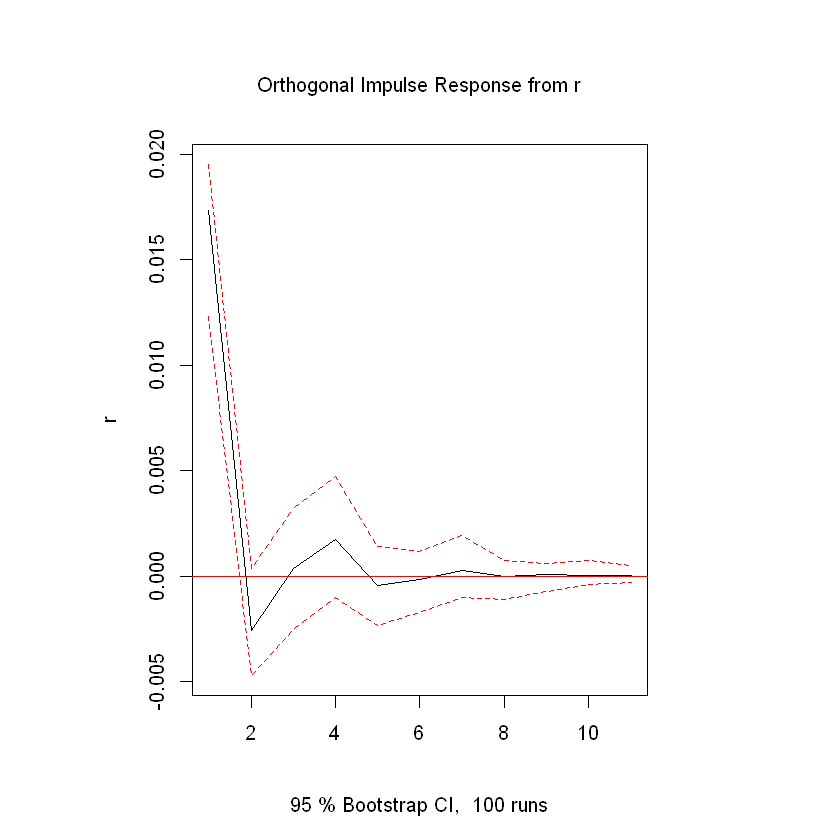

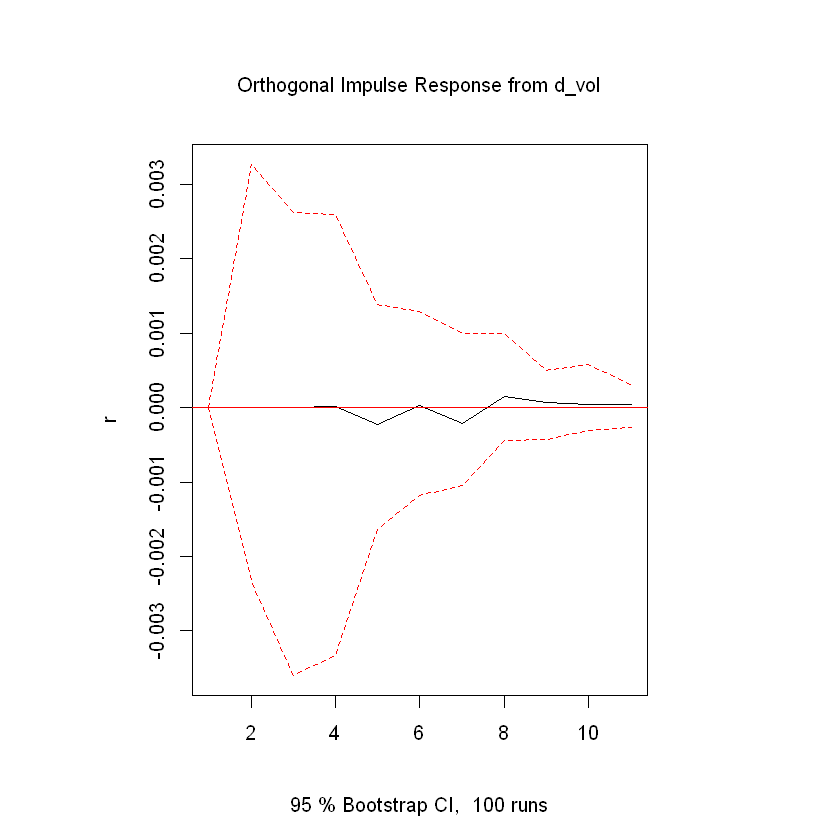

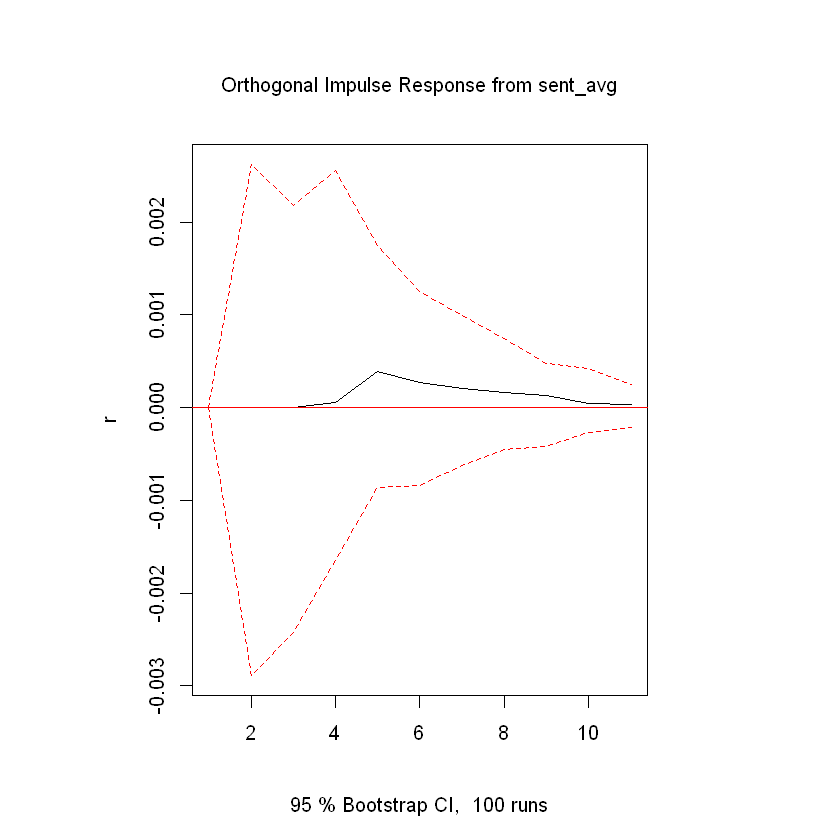

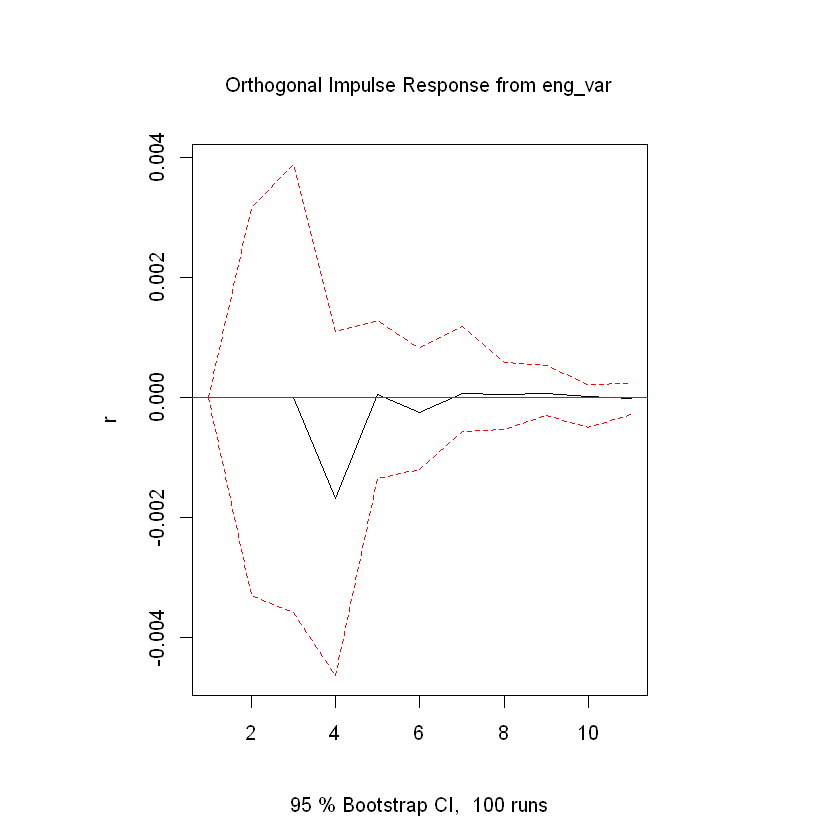

In [71]:
var_1 <- VAR(df_train, p = 3)

var_2 <- restrict(var_1,thresh = 1)
summary(var_2)

var_irf <- irf(var_2, response = "r")
plot(var_irf)

In [72]:
#VARX model---------------

x1 <- VAR(df_end_train, 7, exogen = df_ex_train)

x2 <- restrict(x1, method = "ser")
summary(x2)


VAR Estimation Results:
Endogenous variables: r, d_vol 
Deterministic variables: const 
Sample size: 102 
Log Likelihood: 307.852 
Roots of the characteristic polynomial:
0.8289 0.8289 0.8238 0.8238 0.8049 0.8025 0.8025 0.7651 0.7651 0.7277 0.7277 0.6611     0     0
Call:
VAR(y = df_end_train, p = 7, exogen = df_ex_train)


Estimation results for equation r: 
r = r.l5 + d_vol.l7 

          Estimate Std. Error t value Pr(>|t|)  
r.l5     -0.215740   0.094459  -2.284   0.0245 *
d_vol.l7 -0.021266   0.008211  -2.590   0.0110 *
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


Residual standard error: 0.01617 on 100 degrees of freedom
Multiple R-Squared: 0.1022,	Adjusted R-squared: 0.08425 
F-statistic: 5.692 on 2 and 100 DF,  p-value: 0.004559 


Estimation results for equation d_vol: 
d_vol = d_vol.l2 + d_vol.l4 + r.l5 

         Estimate Std. Error t value Pr(>|t|)  
d_vol.l2 -0.22925    0.09673  -2.370   0.0197 *
d_vol.l4 -0.21010    0.09647  -2.178   0.0318 *
r.l5